# Compute embeddings from race ranking data

Here's the next step! The algorithm finds hidden factors (called embeddings) that summarize a racer's and a race's profile. Inspired from this [Kaggle notebook](https://www.kaggle.com/code/sborms/collaborative-filtering-deep-dive).

_This is just for running along and testing, and does not generate the final results!_ A script version of part of this notebook is in `scripts/train.py`.

In [1]:
print(f"\33[1m\33[33mLet's go\33[0m!")

Let's go!


## Imports

In [2]:
import sys
import numpy as np
import pandas as pd
from fastai.collab import *
from fastai.tabular.all import *

sys.path.append("../")
from src.utils import *

## Functions

## Config

In [3]:
CURR_YEAR = 2023
NORMALIZE_HOW = "bins"  # "0-1", "1-20", "bins"
MIN_N_PARTICIPATIONS = 20  # a rider is considered only if they did at least this amount of race participations
N_FACTORS = 10  # number of hidden factors
Y_RANGE = (0, 5.25 * 2)  # (0, 1) or (1, 20.5) or (0, 5.25), multiply by max. of race class weighting

## Compute embeddings

In [4]:
df_results = pd.read_csv("../data/df_race_results.csv",
                         index_col=[0, 1, 2],
                         dtype={"year": str, "stage_slug": str, "class": str})

In [5]:
df_results = df_results[df_results.columns[df_results.count(axis=0) >= MIN_N_PARTICIPATIONS]]

In [6]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                        class               
2022 omloop-het-nieuwsblad/2022/result 1.UWT            1.0
     paris-nice/2022/gc                2.UWT           32.0
     paris-nice/2022/stage-1/result    2.UWT            3.0
     paris-nice/2022/stage-2/result    2.UWT            2.0
     paris-nice/2022/stage-3/result    2.UWT            3.0

In [7]:
df_results = normalize_results_by_race(df_results, how=NORMALIZE_HOW)
df_results = df_results.astype(float)

In [8]:
df_results.filter(regex="VAN AERT Wout").dropna().head()

VAN AERT Wout
year stage_slug                        class               
2022 omloop-het-nieuwsblad/2022/result 1.UWT            5.0
     paris-nice/2022/gc                2.UWT            1.0
     paris-nice/2022/stage-1/result    2.UWT            5.0
     paris-nice/2022/stage-2/result    2.UWT            5.0
     paris-nice/2022/stage-3/result    2.UWT            5.0

In [9]:
df_reweight = df_results.index.to_frame().reset_index(drop=True)

In [10]:
df_reweight["w_year"] = df_reweight["year"].astype(int).apply(get_year_weight, curr_year=CURR_YEAR)
df_reweight["w_class"] = df_reweight["class"].str.partition(".")[2].apply(get_race_class_weight)
df_reweight["w_stage"] = df_reweight["stage_slug"].str.contains("/stage-").apply(get_stage_weight)
df_reweight["w_gc"] = df_reweight["stage_slug"].str.contains("/gc").apply(get_gc_weight)
df_reweight["w"] = df_reweight["w_year"] * df_reweight["w_class"] * df_reweight["w_stage"] * df_reweight["w_gc"]
df_reweight.set_index(["year", "stage_slug", "class"], inplace=True)

In [11]:
print(sorted(np.round(df_reweight["w"].unique(), 2)))

[0.27, 0.35, 0.39, 0.41, 0.49, 0.5, 0.52, 0.58, 0.62, 0.73, 0.75, 0.82, 0.94, 1.05, 1.09, 1.17, 1.4, 1.46, 1.5, 1.56, 1.88, 1.95, 2.0, 2.5]


In [12]:
# scale race results by weights
df_results.loc[:, :] = df_results.to_numpy() * df_reweight[["w"]].to_numpy()

In [13]:
df_results.filter(regex="VAN AERT Wout").dropna().sample(5)

VAN AERT Wout
year stage_slug                            class               
2023 tirreno-adriatico/2023/stage-4/result 2.UWT       1.400000
2022 bretagne-classic/2022/result          1.UWT       7.788008
2023 tour-de-france/2023/stage-7/result    2.UWT       1.400000
2022 tour-de-france/2022/stage-17/result   2.UWT       1.090321
     paris-nice/2022/stage-2/result        2.UWT       5.451605

In [14]:
df = pd.melt(df_results.reset_index(drop=False).drop(columns=["year", "class"]), id_vars="stage_slug")
df.rename(columns={"stage_slug": "stage", "variable": "rider", "value": "result"}, inplace=True)
df = df[["rider", "stage", "result"]]  # rider = user, stage (race) = item, result = rating

In [15]:
df_ = df.dropna()
df_.rider.nunique(), df_.stage.nunique()

(1996, 1385)

In [16]:
dls = CollabDataLoaders.from_df(df_, bs=64)
dls.show_batch()

c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\data\transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
c:\Users\saborms\Desktop\GITHUB\cyclingsimilarity.com\.venv\lib\site-packages\fastai\tabular\core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


,rider,stage,result
0,FREDDI Matteo,settimana-internazionale-coppi-e-bartali/2023/stage-5/result,0.525000
1,DE KEIJZER Gerd,tour-de-pologne/2022/stage-3/result,1.090321
2,DOĞAN Halil İbrahim,tour-of-turkey/2022/stage-4/result,0.408870
3,CICCONE Giulio,tour-de-france/2022/stage-12/result,3.270963
4,HOFSTETTER Hugo,dwars-door-het-hageland/2023/result,3.000000
5,EEKHOFF Nils,tour-de-france/2023/stage-8/result,5.600000
6,FEDERSPIEL Daniel,circuit-des-ardennes-international/2023/gc,0.625000
7,JOYCE Colin,grand-prix-criquielion/2022/result,2.336402
8,LECROQ Jérémy,boucles-de-la-mayenne/2022/stage-4/result,3.270963
9,TEUGELS Lennert,international-tour-of-hellas/2023/stage-1/result,0.525000


In [17]:
learn = collab_learner(dls, n_factors=N_FACTORS, y_range=Y_RANGE)

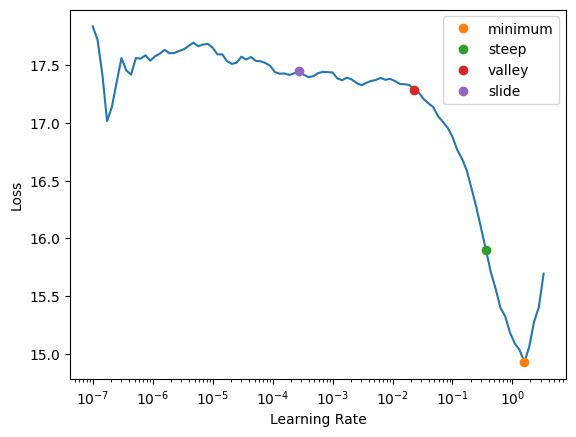

In [18]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [19]:
learn.fit_one_cycle(5, lrs.valley, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.930177,0.958016,00:17
1,0.892677,0.914303,00:16
2,0.757049,0.772798,00:16
3,0.585123,0.636379,00:16
4,0.587787,0.594075,00:16


In [20]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(1997, 10)
  (i_weight): Embedding(1386, 10)
  (u_bias): Embedding(1997, 1)
  (i_bias): Embedding(1386, 1)
)

In [21]:
learn.export("../data/learner.pkl")

## Interpretation

### Bias

In [22]:
rider_bias = extract_bias(learn, "rider")
[dls.classes["rider"][i] for i in rider_bias.argsort(descending=True)[:10]]  # "best"/most consistent riders across all seasons

['POGAČAR Tadej',
 'EVENEPOEL Remco',
 'YATES Adam',
 'VINGEGAARD Jonas',
 '#na#',
 'YATES Simon',
 'VAN AERT Wout',
 'PEDERSEN Mads',
 'ROGLIČ Primož',
 'SKJELMOSE Mattias']

In [23]:
race_bias = extract_bias(learn, "stage")
[dls.classes["stage"][i] for i in race_bias.argsort(descending=True)[:10]]

['#na#',
 'volta-a-catalunya/2023/gc',
 'giro-d-italia/2023/gc',
 'tour-of-qinghai-lake/2022/gc',
 'tour-de-romandie/2023/gc',
 'tour-de-suisse/2023/gc',
 'paris-nice/2023/stage-3/result',
 'vuelta-a-burgos/2023/gc',
 'e3-harelbeke/2023/result',
 'tour-down-under/2023/gc']

### PCA

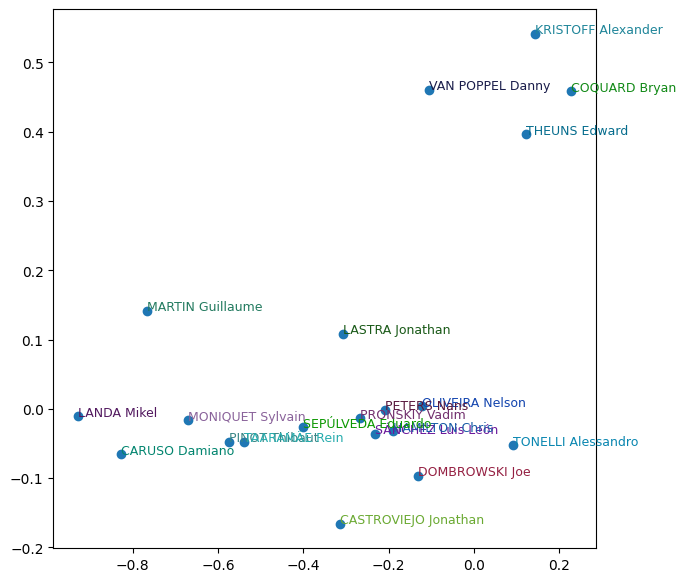

In [24]:
plot_pca(df, learn, "rider", n_plot=20)

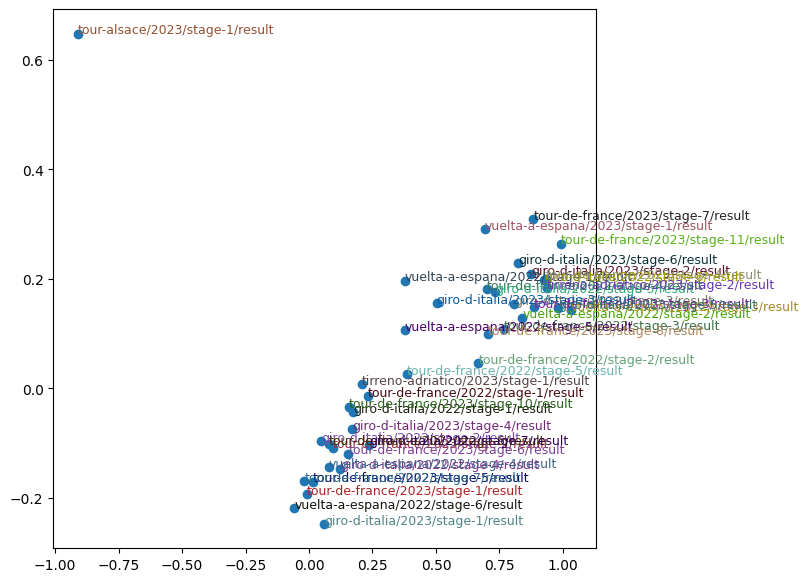

In [25]:
plot_pca(df, learn, "stage", n_plot=40)

### Similarity

In [26]:
spotcheck_riders = ["VAN AERT Wout", "VAN DER POEL Mathieu", "VAN AVERMAET Greg", "ALAPHILIPPE Julian", "POGAČAR Tadej", "EVENEPOEL Remco", "MAS Enric"]
for r in spotcheck_riders:
    print(r.ljust(20), "|", extract_most_similar_elements(learn, "rider", r, 7))

VAN AERT Wout        | ['PEDERSEN Mads', 'PHILIPSEN Jasper', 'LAPORTE Christophe', 'GIRMAY Biniam', 'DÉMARE Arnaud', 'KOOIJ Olav', 'GROENEWEGEN Dylan']
VAN DER POEL Mathieu | ['MOHORIČ Matej', 'KÜNG Stefan', 'HIRSCHI Marc', 'TEUNS Dylan', 'BENOOT Tiesj', 'COSTA Rui', 'ROTA Lorenzo']
VAN AVERMAET Greg    | ['GUERNALEC Thibault', 'GRÉGOIRE Romain', 'HERMANS Quinten', 'CEPEDA Jefferson Alexander', 'KONRAD Patrick', 'CALMEJANE Lilian', 'CARR Simon']
ALAPHILIPPE Julian   | ['SKUJIŅŠ Toms', 'LAZKANO Oier', 'LASTRA Jonathan', 'GARCÍA PIERNA Raúl', 'COSTIOU Ewen', 'ADRIÀ Roger', 'FABBRO Matteo']
POGAČAR Tadej        | ['ROGLIČ Primož', 'VINGEGAARD Jonas', 'EVENEPOEL Remco', 'YATES Adam', 'MAS Enric', 'ALMEIDA João', 'YATES Simon']
EVENEPOEL Remco      | ['ROGLIČ Primož', 'ALMEIDA João', 'VLASOV Aleksandr', 'MAS Enric', 'YATES Adam', 'POGAČAR Tadej', 'YATES Simon']
MAS Enric            | ['VLASOV Aleksandr', 'YATES Adam', 'RODRÍGUEZ Carlos', 'ALMEIDA João', 'AYUSO Juan', 'YATES Simon', 'GEOGHEG

In [27]:
spotcheck_stages = ["paris-roubaix/2022/result", "dauphine/2022/stage-6/result", "liege-bastogne-liege/2022/result"]
for r in spotcheck_stages:
    print(r, "\n", extract_most_similar_elements(learn, "stage", r, 10), "\n", sep="")

paris-roubaix/2022/result
['tour-of-belgium/2022/stage-4/result', 'tour-of-belgium/2023/stage-4/result', 'tour-du-poitou-charentes-et-de-la-vienne/2022/gc', 'tour-of-denmark/2022/stage-2/result', 'tour-du-poitou-charentes-et-de-la-vienne/2023/gc', 'adriatica-ionica-2022/gc', 'tour-of-slovenia/2023/stage-5/result', 'czech-tour/2023/gc', 'tour-of-britain/2023/stage-7/result', 'tour-de-wallonie/2023/stage-4/result']

dauphine/2022/stage-6/result
['uae-tour/2022/stage-1/result', 'tour-de-france/2022/stage-21/result', 'tirreno-adriatico/2022/stage-2/result', 'tour-de-france/2022/stage-15/result', 'vuelta-a-la-comunidad-valenciana/2022/stage-5/result', 'paris-nice/2022/stage-3/result', 'tour-de-france/2022/stage-2/result', 'itzulia-basque-country/2022/stage-2/result', 'vuelta-a-la-comunidad-valenciana/2022/stage-4/result', 'tour-of-slovenia/2023/stage-2/result']

liege-bastogne-liege/2022/result
['vuelta-a-espana/2022/stage-4/result', 'la-route-d-occitanie/2022/stage-3/result', 'amstel-gold-